In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

In [128]:
df1 = pd.read_csv('heart.csv')
df2 = pd.read_csv('heart.csv')

In [129]:
def remove_outliers(df,column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1 - 1.5*IQR
  upper = Q3 + 1.5*IQR
  return df[(df[column] >= lower) & (df[column] <= upper)]

In [130]:
df1.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [131]:
df1.describe()
#resting bp cannot be 0

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [132]:
#replaced 0s with NaNs and then NaNs with means
df1['resting bp s'].replace(0,np.NaN)
df1['resting bp s'].fillna(df1['resting bp s'].mean(), inplace = True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [133]:
#scled all numeric values
columns_to_scale = list(df1.columns[:-1])
numeric_data = df1[columns_to_scale]
scaler = StandardScaler()
scaler.fit(numeric_data)
scaled_data = scaler.transform(numeric_data)
df1[columns_to_scale] = scaled_data
df1

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,-1.466728,0.555995,-1.318351,0.427328,0.775674,-0.520929,-0.802672,1.265039,-0.795219,-0.849792,-1.023217,0
1,-0.504600,-1.798576,-0.248932,1.516587,-0.299512,-0.520929,-0.802672,0.637758,-0.795219,0.071119,0.615583,1
2,-1.787437,0.555995,-1.318351,-0.117301,0.716489,-0.520929,0.346762,-1.636136,-0.795219,-0.849792,-1.023217,0
3,-0.611503,-1.798576,0.820487,0.318402,0.035867,-0.520929,-0.802672,-1.244085,1.257515,0.531575,0.615583,1
4,0.029915,0.555995,-0.248932,0.971958,-0.151550,-0.520929,-0.802672,-0.695214,-0.795219,-0.849792,-1.023217,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,-0.932213,0.555995,-2.387770,-1.206560,0.529071,-0.520929,-0.802672,-0.303164,-0.795219,0.255301,0.615583,1
1186,1.526558,0.555995,0.820487,0.645180,-0.171279,1.919646,-0.802672,0.049682,-0.795219,2.281307,0.615583,1
1187,0.350624,0.555995,0.820487,-0.117301,-0.782852,-0.520929,-0.802672,-0.969650,1.257515,0.255301,0.615583,1
1188,0.350624,-1.798576,-1.318351,-0.117301,0.252877,-0.520929,1.496197,1.343449,-0.795219,-0.849792,0.615583,1


In [134]:
outcome_correlation = (df1.corr()['target']).sort_values()
outcome_correlation

max heart rate        -0.413278
cholesterol           -0.198366
resting ecg            0.073059
resting bp s           0.121415
fasting blood sugar    0.216695
age                    0.262029
sex                    0.311267
oldpeak                0.398385
chest pain type        0.460127
exercise angina        0.481467
ST slope               0.505608
target                 1.000000
Name: target, dtype: float64

In [135]:
df1.drop(['cholesterol','resting ecg','resting bp s'], inplace = True, axis = 1)
df1

,age,sex,chest pain type,fasting blood sugar,max heart rate,exercise angina,oldpeak,ST slope,target
0,-1.466728,0.555995,-1.318351,-0.520929,1.265039,-0.795219,-0.849792,-1.023217,0
1,-0.504600,-1.798576,-0.248932,-0.520929,0.637758,-0.795219,0.071119,0.615583,1
2,-1.787437,0.555995,-1.318351,-0.520929,-1.636136,-0.795219,-0.849792,-1.023217,0
3,-0.611503,-1.798576,0.820487,-0.520929,-1.244085,1.257515,0.531575,0.615583,1
4,0.029915,0.555995,-0.248932,-0.520929,-0.695214,-0.795219,-0.849792,-1.023217,0
...,...,...,...,...,...,...,...,...,...
1185,-0.932213,0.555995,-2.387770,-0.520929,-0.303164,-0.795219,0.255301,0.615583,1
1186,1.526558,0.555995,0.820487,1.919646,0.049682,-0.795219,2.281307,0.615583,1
1187,0.350624,0.555995,0.820487,-0.520929,-0.969650,1.257515,0.255301,0.615583,1
1188,0.350624,-1.798576,-1.318351,-0.520929,1.343449,-0.795219,-0.849792,0.615583,1


<Axes: ylabel='oldpeak'>

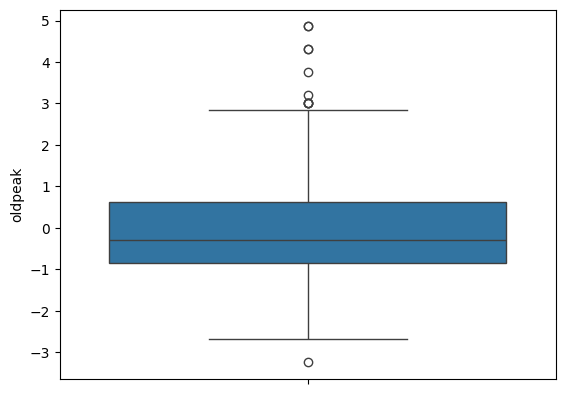

In [136]:
#remove outliers for all numerical columns
#for name in columns_to_scale:
#  i1,i2 = remove_outliers(df1,name)
#  df1.drop(index=i1, inplace=True)
#  df1.drop(index=i2, inplace=True)
sns.boxplot(df1['oldpeak'])
#oldpeak has outliers

<Axes: ylabel='max heart rate'>

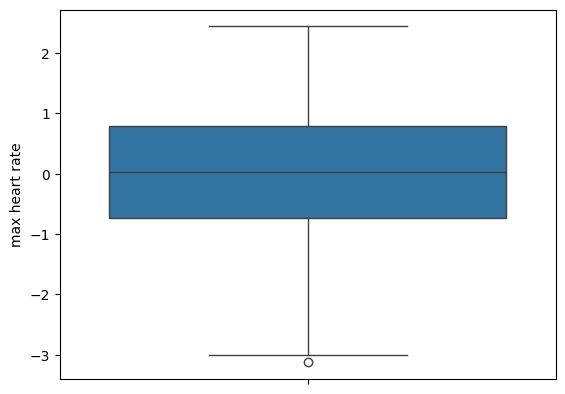

In [137]:
#max heart rate has one outlier
sns.boxplot(df1['max heart rate'])

In [138]:
#outliers have been removed
# outlier_columns = ['max heart rate','oldpeak']
# for column in outlier_columns:
#   df2 = remove_outliers(df1,column)
# df2.reset_index(drop=True, inplace=True)

In [139]:
#shuffle all data
df1 = df1.sample(frac=1, random_state=50)

In [140]:
#splitting x train and y train
y = df1['target']
X = df1.drop('target', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 50)

print(X_train.shape)
print(y_train.shape)

(952, 8)
(952,)


In [141]:
classifiers = {
    # 'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=50),
    'Logistic Regression': LogisticRegression()
}

# Define hyperparameters grid for each classifier
# param_grids = {
#     'SVM': {
#         'C': [0.1, 1, 10],
#         'gamma': ['scale', 'auto'],
#         'kernel': ['rbf', 'linear']
#     },
#     'KNN': {
#         'n_neighbors': [3, 5, 7],
#         'weights': ['uniform', 'distance']
#     },
#     'Random Forest': {
#         'n_estimators': [50, 100],
#         'max_depth': [None, 10],
#         'min_samples_split': [2, 5],
#         'max_features': ['sqrt', 'log2']
#     },
#     'Logistic Regression': {
#         'solver': ['saga', 'liblinear'],
#         'penalty': ['l1', 'l2'],
#         'C': [0.1, 1, 10],
#         'max_iter': [100, 500]
#     }
# }

param_grids = {
    # 'SVM': {
    #     'C': [0.1, 1, 10, 100, 1000],
    #     'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
    #     'kernel': ['rbf','linear']
    # },
    'KNN': {
        'n_neighbors': [3,4,5,6,7,8,9,10],
        'weights': ['uniform', 'distance']
    },
    'Random Forest': {
      'n_estimators': [50, 100, 150],
      'max_depth': [None, 10, 20],
      'min_samples_split': [2, 5, 10],
      'max_features': ['sqrt', 'log2']
    },
    # 'HistGradientBoosting': {
    #     'learning_rate': [0.1, 0.01, 0.001],
    #     'max_iter': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
    # },
    'Logistic Regression':{'solver': ['saga', 'liblinear'],
                  'penalty': ['l1','l2'],
                 'C': [0.001,0.01,0.1,1,10,100,1000],
                  'max_iter' : [10,100,500]}
}


# param_grids = {
#     'SVM': {
#         'C': [0.1],
#         'gamma': ['scale', 'auto'],
#         'kernel': ['rbf', 'linear']
#     },
#     'KNN': {
#         'n_neighbors': [3, 5, 7],
#         'weights': ['uniform', 'distance']
#     },
#     'Random Forest': {
#         'n_estimators': [50, 100],
#         'max_depth': [None, 10],
#         'min_samples_split': [2, 5],
#         'max_features': ['sqrt', 'log2']
#     },
#     'Logistic Regression': {
#         'solver': ['saga', 'liblinear'],
#         'penalty': ['l1', 'l2'],
#         'C': [0.1, 1, 10],
#         'max_iter': [100, 500]
#     }
# }

In [142]:
results = {}
for name, classifier in classifiers.items():
    print("Training: ", name)
    gridSearch = GridSearchCV(estimator=classifier, param_grid=param_grids[name], cv=5, n_jobs=-1)
    gridSearch.fit(X_train, y_train)
    results[name] = gridSearch.best_estimator_
results

Training:  KNN
Training:  Random Forest
Training:  Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'KNN': KNeighborsClassifier(weights='distance'),
 'Random Forest': RandomForestClassifier(max_features='log2', random_state=50),
 'Logistic Regression': LogisticRegression(C=0.1, max_iter=10, penalty='l1', solver='saga')}

In [143]:
for name, clf in results.items():
    print("\nResults for", name)
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Results for KNN
Accuracy: 0.9159663865546218

Results for Random Forest
Accuracy: 0.9327731092436975

Results for Logistic Regression
Accuracy: 0.8361344537815126
